In [21]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental import host_callback
from tqdm.auto import tqdm
from functools import partial
import frozen_lake
import plotting
import qlearning
import actions
import mangoenv
import utils
import nets
import optuna

In [17]:
import matplotlib.pyplot as plt

def plot_rewards(rewards):
    def smooth(x, w=0.01):
        return jnp.convolve(x, jnp.ones(int(w * len(x))) / int(w * len(x)), mode="valid")
    for rew in rewards:
        plt.plot(smooth(rew))
    plt.plot(smooth(rewards.mean(axis=0)), label="mean", color="black", linewidth=3)
    plt.show()

In [18]:
def setup_replay_buffer(env, rng_key, n_rollouts, rollout_steps):
    episodes = utils.multi_random_rollout(env, rng_key, rollout_steps, n_rollouts)
    replay_buffer = utils.CircularBuffer.store_episodes(episodes)
    return replay_buffer


def setup_dql_state(env, rng_key, lr, cell_scale):
    reward_fn = actions.get_reward_fn(cell_scale)
    beta_fn = actions.get_beta_fn(cell_scale)
    qnet = nets.MultiTaskQnet(env.action_space.n, n_comands=5)
    dql_state = qlearning.MultiDQLTrainState.create(
        rng_key, qnet, env, reward_fn=reward_fn, beta_fn=beta_fn, lr=lr
    )
    return dql_state


def eval_policy(env, dql_state, rng_key, episodes, steps):
    def eval_single(rng_key):
        transitions = dql_state.greedy_rollout(env, rng_key, steps)
        episodes = jnp.clip(transitions.done.sum(), a_min=1)
        rewards = transitions.reward.sum()
        return rewards, episodes

    rewards, episodes = jax.vmap(eval_single)(jax.random.split(rng_key, episodes))
    return rewards.sum() / episodes.sum()


def train_stage(rng_key, env, dql_state, replay_buffer, n_train_iter, batch_size):
    pbar = tqdm(total=n_train_iter, desc="Training")

    def train_step(dql_state, rng_key):
        rng_train, rng_eval = host_callback.id_tap(
            lambda a, t: pbar.update(1), jax.random.split(rng_key)
        )
        dql_state = dql_state.update_params(replay_buffer.sample(rng_train, batch_size))
        accuracy = eval_policy(env, dql_state, rng_eval, episodes=64, steps=5)
        return dql_state, accuracy

    rng_steps = jax.random.split(rng_key, n_train_iter)
    dql_state, accuracy_evolution = jax.lax.scan(train_step, dql_state, rng_steps)
    return dql_state, accuracy_evolution


def setup_env(map_scale, p, cell_scales, rng_key):
    rng_env, rng_stage = jax.random.split(rng_key)
    env = frozen_lake.FrozenLake.make_random(rng_env, map_scale, p)
    if len(cell_scales) == 0:
        return env
    raise NotImplementedError("Not implemented yet")

In [19]:
def get_objective_fn(map_scale, cell_scales, max_steps, p=0.5, n_sims=32):
    multi_env_setup = jax.jit(jax.vmap(partial(setup_env, map_scale, p, cell_scales[:-1])))
    multi_replay_buffer_setup = jax.jit(
        jax.vmap(setup_replay_buffer, in_axes=(0, 0, None, None)),
        static_argnames=("n_rollouts", "rollout_steps"),
    )
    multi_dql_state_setup = jax.jit(
        jax.vmap(partial(setup_dql_state, cell_scale=cell_scales[-1]), in_axes=(0, 0, None)),
        static_argnames=("lr",),
    )
    multi_train_stage = jax.jit(
        jax.vmap(train_stage, in_axes=(0, 0, 0, 0, None, None)),
        static_argnames=("n_train_iter", "batch_size"),
    )

    def objective(trial: optuna.Trial) -> jnp.float_:
        lr = trial.suggest_float("lr", 1e-4, 1e-4, log=True)
        rollout_steps = 2 ** trial.suggest_int("log_rollout_steps", 2, 7)  # 4 to 128
        batch_size = 2 ** trial.suggest_int("log_batch_size", 7, 10)  # 128 to 1024
        n_rollouts = max_steps // rollout_steps
        train_iter = max_steps // batch_size

        # attributes
        seed = trial.number
        trial.set_user_attr("seed", seed)
        trial.set_user_attr("map_scale", map_scale)
        trial.set_user_attr("cell_scales", cell_scales)
        trial.set_user_attr("train_iter", train_iter)
        trial.set_user_attr("n_rollouts", n_rollouts)

        rng_key = jax.random.PRNGKey(seed)
        rng_env, rng_rollout, rng_init, rng_train = jax.random.split(rng_key, 4)
        rng_env = jax.random.split(rng_env, n_sims)
        rng_rollout = jax.random.split(rng_rollout, n_sims)
        rng_init = jax.random.split(rng_init, n_sims)
        rng_train = jax.random.split(rng_train, n_sims)

        envs = multi_env_setup(rng_env)
        replay_buffers = multi_replay_buffer_setup(envs, rng_rollout, n_rollouts, rollout_steps)
        dql_states = multi_dql_state_setup(envs, rng_init, lr)
        dql_states, accuracy_evol = multi_train_stage(
            rng_train, envs, dql_states, replay_buffers, train_iter, batch_size
        )

        accuracy_evol = np.asarray(accuracy_evol.block_until_ready())
        plot_rewards(accuracy_evol)
        trial.set_user_attr("accuracy_evol", accuracy_evol)
        return accuracy_evol.mean()

    return objective

[I 2024-02-29 20:29:40,611] A new study created in RDB with name: mango


  0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/1024 [00:00<?, ?it/s]

Greedy Rollout:   0%|          | 0/5 [00:00<?, ?it/s]

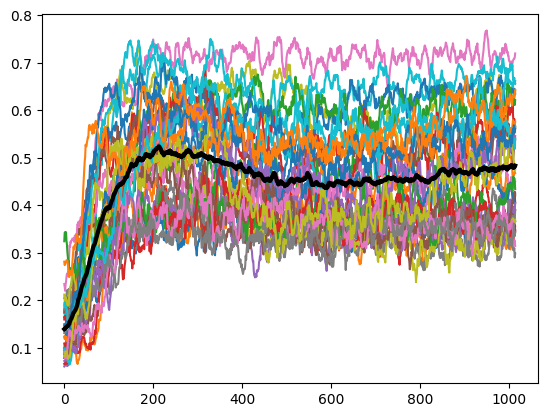

[W 2024-02-29 20:29:58,999] Trial 0 failed with parameters: {'lr': 0.0001, 'log_rollout_steps': 3, 'log_batch_size': 10} because of the following error: TypeError('Object of type ArrayImpl is not JSON serializable').
Traceback (most recent call last):
  File "/home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_952991/2437547540.py", line 46, in objective
    trial.set_user_attr("accuracy_evol", accuracy_evol)
  File "/home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/optuna/trial/_trial.py", line 595, in set_user_attr
    self.storage.set_trial_user_attr(self._trial_id, key, value)
  File "/home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/optuna/storages/_cached_storage.py", line 195, in set_trial_user_attr
    self._backend.set_trial_user_attr(trial_id, key=key, value=value)
  File "/home/davide_sartor/.conda/envs/dl_env/lib/py

TypeError: Object of type ArrayImpl is not JSON serializable

In [20]:
map_scale = 2
cell_scales = (1,)

storage_path = f"sqlite:///optuna_studies/{2**map_scale}x{2**map_scale}_stages={list(cell_scales)}.db"
study = optuna.create_study(
    study_name=f"mango",
    storage=storage_path,
    load_if_exists=True,
    direction="maximize",
)
study.optimize(
    get_objective_fn(map_scale, cell_scales, max_steps=1024*1024),
    n_trials=64,
    show_progress_bar=True,
)

In [ ]:
map_scale = 2
cell_scales = (2,)
storage_path = f"{2**map_scale}x{2**map_scale}_stages={list(cell_scales)}.db"

cmd = f"optuna-dashboard 'sqlite:///optuna_studies/{storage_path}'"
get_ipython().system(cmd)

Traceback (most recent call last):
  File "/home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/sqlalchemy/engine/base.py", line 1965, in _exec_single_context
    self.dialect.do_execute(
  File "/home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 921, in do_execute
    cursor.execute(statement, parameters)
sqlite3.OperationalError: no such table: version_info

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/optuna/storages/_rdb/storage.py", line 73, in _create_scoped_session
    yield session
  File "/home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/optuna/storages/_rdb/storage.py", line 1043, in _init_version_info_model
    version_info = models.VersionInfoModel.find(session)
  File "/home/davide_sartor/.conda/envs/dl_env/lib/python3.10/site-packages/optuna/storages/_rd